# Amazon Food Reviews prediction - Pavel Novotný - Lundegaard interview

## Package import and data load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn import metrics
from sklearn.metrics import classification_report 
import itertools
from sklearn.metrics import roc_auc_score


from nltk import PorterStemmer

from imblearn.under_sampling import RandomUnderSampler

import sklearn
import string
import re

In [3]:
with open('foods.txt','r', encoding='latin-1') as f:
    data = f.read()
columns_list=['product/productId',
 'review/helpfulness',
 'review/profileName',
 'review/score',
 'review/summary',
 'review/text',
 'review/time',
 'review/userId']

df=pd.DataFrame([
    {line.split(': ')[0]:': '.join(line.split(': ')[1:]) 
     for line in record.split('\n') if line.split(': ')[0] in columns_list}
    for record in data.split('\n\n')])

## Data preparation and EDA

#### renaming columns for easier annotation

In [4]:
df = df.rename(columns={
    'product/productId':'product_id',
    'review/userId':'user_id',
    'review/profileName': 'username',
    'review/helpfulness':'helpfulness',
    'review/score':'rating',
    'review/time':'time',
    'review/summary':'summary',
    'review/text':'text'
})

#### missing values check:

In [5]:
df.isna().sum()

product_id     1
user_id        1
username       1
helpfulness    1
rating         1
time           1
summary        1
text           1
dtype: int64

#### all missing values within one observation -> delete:

In [6]:
df.loc[df['product_id'].isna()]

,product_id,user_id,username,helpfulness,rating,time,summary,text
568454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = df.loc[~df['product_id'].isna()]

#### How are the ratings distributed?

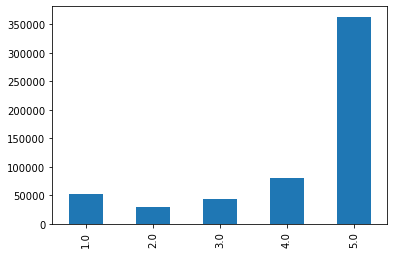

In [8]:
#sort_index() to print bars sorted from 1 to 5
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [9]:
distribution = df['rating'].value_counts()/df.shape[0]
print(f'distribution is: \n {distribution}') 

distribution is: 
 5.0    0.638789
4.0    0.141885
1.0    0.091948
3.0    0.075010
2.0    0.052368
Name: rating, dtype: float64


#### How many ratings per book? How many ratings per user?

In [10]:
rating_counts_eda = df.groupby(by='product_id')['rating'].count().reset_index()
rating_counts_eda = rating_counts_eda.rename(columns={'rating':'rating_counts'})
rating_counts_eda.describe()

,rating_counts
count,74258.000000
mean,7.655121
std,26.453485
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,913.000000


<AxesSubplot:ylabel='Frequency'>

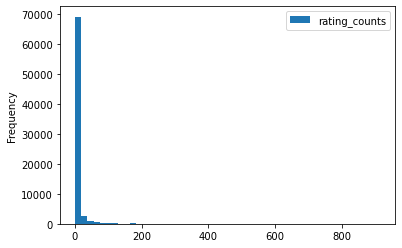

In [11]:
rating_counts_eda.plot(kind='hist',bins=50)

In [12]:
rating_counts_eda_user = df.groupby(by='user_id')['rating'].count().reset_index()
rating_counts_eda_user = rating_counts_eda_user.rename(columns={'rating':'rating_user_count'})
rating_counts_eda_user[['rating_user_count']].describe()

,rating_user_count
count,256059.000000
mean,2.220012
std,4.443361
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,448.000000


<AxesSubplot:ylabel='Frequency'>

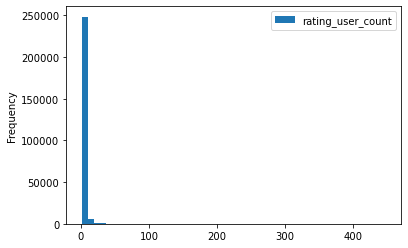

In [13]:
rating_counts_eda_user.plot(kind='hist',bins=50)

In [14]:
#ratings to integer
df['rating'] = df['rating'].astype(float)
df['rating'] = df['rating'].astype(int)

### The target class is imbalanced - will downsample the majority class by doing a simple random sample of N=100000 (each target class 20000)

I'm working with the subsample of 100 000 observations, the size choice was arbitrary due to memory limitations but I supppose the more data I would use for training, the better the results.

In [15]:
df_balanced_sample = df.groupby('rating').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)
df_balanced_sample['rating'].value_counts()

1    20000
2    20000
3    20000
4    20000
5    20000
Name: rating, dtype: int64

# Text Classification (sentiment analysis) of the reviews

## Train test split

Alternatively, k-fold cross validation could be used. To be precise, I should also set aside a hold-out set and do final one time test of the model on it, but since I'm rather demonstrating various possible solutions than looking for the best model, I leave this step out of the process.

In [16]:
X = df_balanced_sample.text
y = df_balanced_sample.rating

assert X.shape == y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=16, test_size=0.20,stratify=y)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape

print(f' Size of Training data is {X_train.shape} \n Size of Test Data: {X_test.shape}')

 Size of Training data is (80000,) 
 Size of Test Data: (20000,)


#### Stop words removal function definition

In [17]:
stopwords = _stop_words.ENGLISH_STOP_WORDS
def preprocess_text(documents):
    documents = "".join([char for char in documents if char not in string.punctuation and not char.isdigit()])
    clean_docs = " ".join([token for token in documents.split() if not token in stopwords])
    
    return clean_docs

#### Confusion matrix function definition

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

## 1. Lower case

In [19]:
X_train = [row.lower() for row in X_train]
X_test = [row.lower() for row in X_test]

## 2. Stemming

Alternatively, I could have used lemmatization, but that would require larger computational resources.

In [20]:
porter = PorterStemmer()
X_train = [porter.stem(t) for t in X_train]
X_test = [porter.stem(t) for t in X_test]

## 3a Bag of Words 

In [21]:
vectorizer = CountVectorizer(preprocessor=preprocess_text, stop_words = stopwords)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

## 3b Bag of n-grams

`max_features = 2000` due to memory limitations

In [22]:
vect_ngrams = CountVectorizer(preprocessor=preprocess_text, stop_words = stopwords,ngram_range=(1,3),max_features=2000)
X_train_ng = vect_ngrams.fit_transform(X_train)
X_test_ng = vect_ngrams.transform(X_test)

## 3c TF-IDF

In [23]:
tfidf = TfidfVectorizer(preprocessor=preprocess_text, stop_words=stopwords)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Modelling

## 1a. Logistic Regression - on BoW

In [24]:
logreg = LogisticRegression(multi_class='multinomial',random_state=16)
logreg.fit(X_train_bow, y_train) 
y_pred_bow = logreg.predict(X_test_bow)

/Users/Pavel/opt/anaconda3/envs/lunde/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Evaluation

              precision    recall  f1-score   support

           1       0.64      0.66      0.65      4000
           2       0.52      0.51      0.52      4000
           3       0.49      0.48      0.49      4000
           4       0.49      0.47      0.48      4000
           5       0.62      0.65      0.63      4000

    accuracy                           0.55     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.55      0.55      0.55     20000

Accuracy:  0.55395


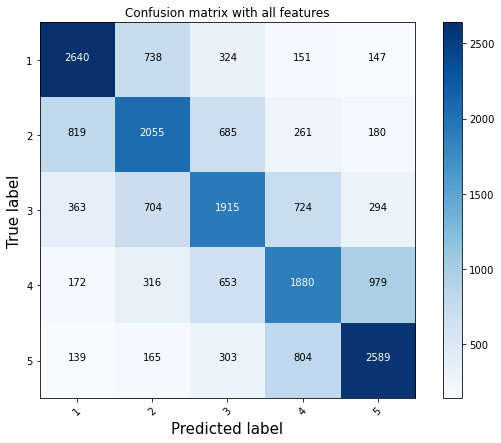

In [25]:
print(classification_report(y_test, y_pred_bow))
print("Accuracy: ", accuracy_score(y_test, y_pred_bow))

cnf_matrix = confusion_matrix(y_test, y_pred_bow)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5],normalize=False,
                      title='Confusion matrix with all features')

## 1b Logistic Regression - on Bag of n-grams

In [26]:
logreg = LogisticRegression(multi_class='multinomial',random_state=16)
logreg.fit(X_train_ng, y_train) 
y_pred_ng = logreg.predict(X_test_ng)

/Users/Pavel/opt/anaconda3/envs/lunde/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.58      0.65      0.61      4000
           2       0.45      0.40      0.42      4000
           3       0.43      0.39      0.41      4000
           4       0.46      0.42      0.44      4000
           5       0.58      0.67      0.62      4000

    accuracy                           0.51     20000
   macro avg       0.50      0.51      0.50     20000
weighted avg       0.50      0.51      0.50     20000

Accuracy:  0.5065


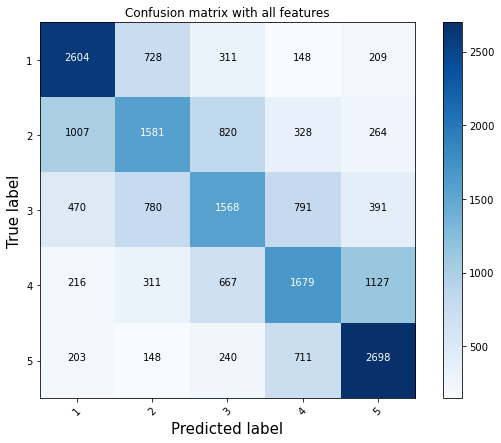

In [27]:
print(classification_report(y_test, y_pred_ng))
print("Accuracy: ", accuracy_score(y_test, y_pred_ng))

cnf_matrix = confusion_matrix(y_test, y_pred_ng)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5],normalize=False,
                      title='Confusion matrix with all features')

## 1c. Logistic Regression - on TFIDF

In [28]:
logreg.fit(X_train_tfidf, y_train) 
y_pred_tfidf = logreg.predict(X_test_tfidf)

/Users/Pavel/opt/anaconda3/envs/lunde/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.63      0.67      0.65      4000
           2       0.50      0.49      0.50      4000
           3       0.49      0.45      0.47      4000
           4       0.49      0.46      0.47      4000
           5       0.61      0.68      0.64      4000

    accuracy                           0.55     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.55      0.55      0.55     20000

Accuracy:  0.55


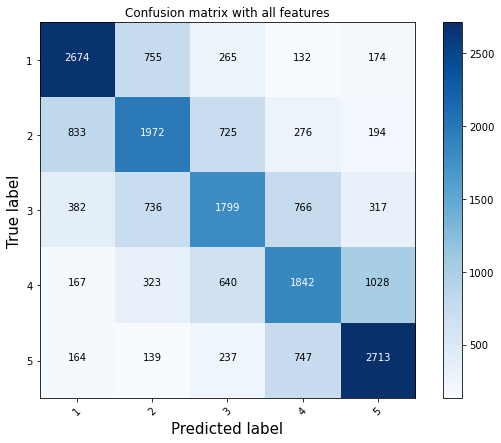

In [29]:
print(classification_report(y_test, y_pred_tfidf))
print("Accuracy: ", accuracy_score(y_test, y_pred_tfidf))

cnf_matrix = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5],normalize=False,
                      title='Confusion matrix with all features')

## 2. Support Vector Machine Classifier - TF-IDF

* I tried fitting the SVM on all the three variants: BoW (acc 0.50), n-grams (acc 0.55) and TF-IDF (acc 0.56) - keeping only the best in the script for better readability
* In proper model tunning of LinearSVC, we could e.g. play with the hyperparameter class_weight in order to drive the performance higher

In [30]:
svc = LinearSVC(class_weight='balanced')
svc.fit(X_train_tfidf, y_train)
y_pred_svc_tfidf = svc.predict(X_test_tfidf)

              precision    recall  f1-score   support

           1       0.63      0.70      0.66      4000
           2       0.54      0.51      0.53      4000
           3       0.53      0.48      0.50      4000
           4       0.51      0.47      0.49      4000
           5       0.61      0.67      0.64      4000

    accuracy                           0.57     20000
   macro avg       0.56      0.57      0.56     20000
weighted avg       0.56      0.57      0.56     20000

Accuracy:  0.5675


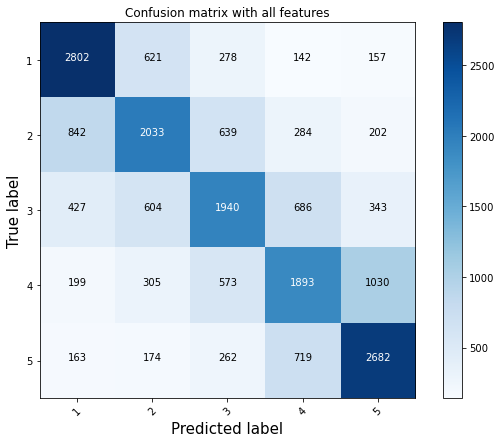

In [31]:
print(classification_report(y_test, y_pred_svc_tfidf))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_svc_tfidf))

cnf_matrix = confusion_matrix(y_test, y_pred_svc_tfidf)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5],normalize=False,
                      title='Confusion matrix with all features')

## 3. Multionmial Naïve Bayes Classifier

* the `class_prior` hyperparameter could be specified to optimize the results


In [32]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb.predict(X_test_tfidf)

              precision    recall  f1-score   support

           1       0.58      0.62      0.60      4000
           2       0.49      0.47      0.48      4000
           3       0.46      0.46      0.46      4000
           4       0.46      0.50      0.47      4000
           5       0.64      0.56      0.60      4000

    accuracy                           0.52     20000
   macro avg       0.52      0.52      0.52     20000
weighted avg       0.52      0.52      0.52     20000

Accuracy:  0.52175


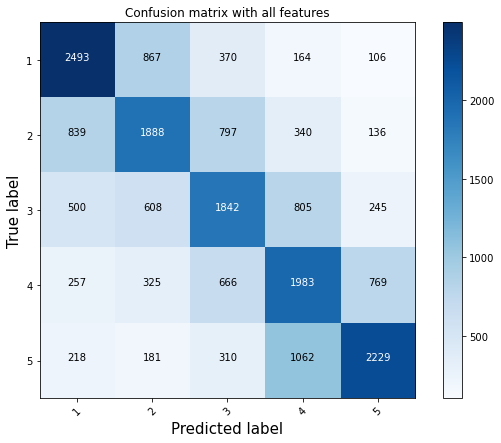

In [33]:
print(classification_report(y_test, y_pred_nb_tfidf))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_nb_tfidf))

cnf_matrix = confusion_matrix(y_test, y_pred_nb_tfidf)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5],normalize=False,
                      title='Confusion matrix with all features')

# Sidenote: modelling with stratified imbalanced classes

* The previous models were all trained on balanced classes as we downsampled the majority class (rating=5).
* Here's a demonstration how the model would tend to predict the majority class over the minority classes if balancing was skipped. The eval. metrics are eventually higher, but they become irrelevant.
* It would come down to domain aspects / business requirements if class balancing is desired or not

In [34]:
N = 20000
stratified = df.groupby('rating', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)


In [39]:
X_strat = stratified.text
y_strat = stratified.rating

assert X_strat.shape == y_strat.shape

X_strat_train, X_strat_test, y_strat_train, y_strat_test = train_test_split(X_strat, X_strat, random_state=16, test_size=0.20,stratify=y_strat)
assert X_strat_train.shape == y_strat_train.shape
assert X_strat_test.shape == y_strat_test.shape

print(f' Size of Training data is {X_strat_train.shape} \n Size of Test Data: {X_strat_test.shape}')

X_strat_train = [row.lower() for row in X_strat_train]
X_strat_test = [row.lower() for row in X_strat_test]


 Size of Training data is (16000,) 
 Size of Test Data: (4000,)


In [40]:
#X_strat_train = [porter.stem(t) for t in X_strat_train]
#X_strat_test = [porter.stem(t) for t in X_strat_test]

In [41]:
X_strat_train_tfidf = tfidf.fit_transform(X_strat_train)
X_strat_test_tfidf = tfidf.transform(X_strat_test)

In [ ]:
logreg.fit(X_strat_train_tfidf, y_strat_train)
pred = logreg.predict(X_strat_test_tfidf)

In [ ]:
#print(classification_report(y_strat_test, pred))
print("Accuracy: ", metrics.accuracy_score(y_strat_test, pred))

cnf_matrix = confusion_matrix(y_strat_test, pred)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5],normalize=False,
                      title='Confusion matrix with all features')

Accuracy:  0.0525


KeyboardInterrupt: 

## Additional remarks, further improvements etc.

* This is by no means the best possible model for the rating prediction as proper hyperparameter tuning (e.g. using gridsearch) could be performed
* I was considering also doing a collaborative filtering (with matrix factorization and then estimating the ratings in the user-item matrix), that would only serve as a prediction for existing users and products, but I think that was not what the task primarily focuses on
* Final and correct testing of the model should be done on a hold-out test set, what I did instead was only train and evaluation, but as mentioned, I was not eager to find the best performing model
* There are several more advanced methods including deep learning, I think these will do for the purpose of the task
* Feature engineering could be done (e.g. deriving number of tokens in each review) as well as getting use of the usefullness of each review